# PCA: Principal Component Analysis

## Notebook Overview - Visualizing LSTM and Autoencoder Performance using PCA
In this notebook, we will explore how well different sequence models—namely LSTM Autoencoders and Dense Autoencoders—are able to reconstruct time series data.
We will use Principal Component Analysis (PCA) to project both the original input sequences and the reconstructed sequences into a 2D space. This dimensionality reduction allows us to visually compare the fidelity of each model’s reconstructions.

### Why PCA?
Reconstruction quality is often measured numerically (e.g., using MSE), but these metrics alone don’t reveal how the reconstructed data is distributed in feature space. 

PCA helps by:
- Providing a visual intuition about reconstruction accuracy.
- Highlighting patterns, clusters, or anomalies in the model’s output.
- Allowing comparative analysis between models in a common projection space.

### Goals of this notebook
- Load or generate reconstructed outputs from trained LSTM and Autoencoder models.
- Flatten the sequential data into a PCA-compatible format.
- Perform PCA on real and reconstructed sequences.
- Visualize how closely each model replicates the structure of the input space.

### Imports

In [1]:
import numpy as np
import pandas as pd
import sys
import os
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, pairwise_distances, explained_variance_score

# Getting src path to import modules
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'src'))

# Adding src path to the system path, if not already added
if src_path not in sys.path:
    sys.path.append(src_path)

from dl_models import AutoencoderKfold as aek
from dl_models import LSTMBasic as lstmb
from utils import plots as plts

## Load & Preprocess the Dataset
Before applying PCA, it is essential to prepare the data properly.
The dataframe is loaded, then the features are selected and scaled to a uniform range (e.g., 0 to 1) using MinMaxScaler.
Scaling ensures that all features contribute equally to the PCA, preventing those with larger ranges from dominating the principal components.

In [2]:
# Time series data for a specific building (Building_1.csv/Building_2.csv/Building_3.csv).
electricity_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/Building_1.csv")

# Carbon intensity data.
carbon_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/carbon_intensity.csv")

# Pricing data.
pricing_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/pricing.csv")

# Weather data.
weather_data = pd.read_csv("../data/citylearn_challenge_2023_phase_1/weather.csv")

# Concatenate multiple datasets along the columns to create a single dataset.
df = pd.concat([electricity_data, carbon_data, pricing_data, weather_data], axis=1)

# Displaying the last 5 samples of the dataframe to show its structure.
df.tail()

,month,hour,day_type,daylight_savings_status,indoor_dry_bulb_temperature,average_unmet_cooling_setpoint_difference,indoor_relative_humidity,non_shiftable_load,dhw_demand,cooling_demand,...,outdoor_dry_bulb_temperature_predicted_24h,outdoor_relative_humidity_predicted_6h,outdoor_relative_humidity_predicted_12h,outdoor_relative_humidity_predicted_24h,diffuse_solar_irradiance_predicted_6h,diffuse_solar_irradiance_predicted_12h,diffuse_solar_irradiance_predicted_24h,direct_solar_irradiance_predicted_6h,direct_solar_irradiance_predicted_12h,direct_solar_irradiance_predicted_24h
715,6,20,6,0,24.468618,0.024173,54.277103,0.442291,0.398354,5.189857,...,32.905895,89.465866,73.861000,40.875510,0.0,110.15520,0.0,0.0,271.32200,0.0
716,6,21,6,0,24.444859,0.000415,54.351337,0.990416,0.199180,4.550693,...,32.669003,87.158066,66.389130,64.036320,0.0,216.20418,0.0,0.0,151.80556,0.0
717,6,22,6,0,24.444464,0.000019,54.532566,1.563732,0.000000,4.043389,...,29.979940,100.000000,58.228535,51.990180,0.0,259.28485,0.0,0.0,374.21823,0.0
718,6,23,6,0,24.444452,0.000009,54.647182,0.421510,0.000000,3.268111,...,28.337627,90.768420,35.361465,60.445404,0.0,272.40073,0.0,0.0,582.50290,0.0
719,6,24,6,0,21.812447,0.145780,63.234272,0.374985,0.000000,6.492827,...,25.415920,82.899440,47.129494,56.078560,0.0,129.96535,0.0,0.0,842.14680,0.0


In [3]:
# Target features to forecast
targets = ['cooling_demand', 'carbon_intensity', 'solar_generation']

# List of features used for training the autoencoder.
features = ['month', 'hour', 'day_type', 'daylight_savings_status', 'indoor_dry_bulb_temperature', 'average_unmet_cooling_setpoint_difference', 
            'indoor_relative_humidity', 'non_shiftable_load', 'dhw_demand', 'cooling_demand', 'heating_demand', 'solar_generation', 'occupant_count', 
            'indoor_dry_bulb_temperature_set_point', 'hvac_mode', 'carbon_intensity', 'electricity_pricing', 
            'electricity_pricing_predicted_6h', 'electricity_pricing_predicted_12h', 'electricity_pricing_predicted_24h', 
            'outdoor_dry_bulb_temperature', 'outdoor_relative_humidity', 'diffuse_solar_irradiance', 'direct_solar_irradiance', 
            'outdoor_dry_bulb_temperature_predicted_6h', 'outdoor_dry_bulb_temperature_predicted_12h', 'outdoor_dry_bulb_temperature_predicted_24h', 
            'outdoor_relative_humidity_predicted_6h', 'outdoor_relative_humidity_predicted_12h', 'outdoor_relative_humidity_predicted_24h', 
            'diffuse_solar_irradiance_predicted_6h', 'diffuse_solar_irradiance_predicted_12h', 'diffuse_solar_irradiance_predicted_24h', 
            'direct_solar_irradiance_predicted_6h', 'direct_solar_irradiance_predicted_12h', 'direct_solar_irradiance_predicted_24h']

In [4]:
# Select the relevant features from the dataframe
X = df[features]

# Print info about the dataframe (number of entries, data types, non-null counts)
print(X.info())

# Initialize the MinMaxScaler to scale features to the range [0, 1]
scaler = MinMaxScaler()

# Fit the scaler on X and transform X to scaled values
X_scaled = scaler.fit_transform(X)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 36 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   month                                       720 non-null    int64  
 1   hour                                        720 non-null    int64  
 2   day_type                                    720 non-null    int64  
 3   daylight_savings_status                     720 non-null    int64  
 4   indoor_dry_bulb_temperature                 720 non-null    float64
 5   average_unmet_cooling_setpoint_difference   720 non-null    float64
 6   indoor_relative_humidity                    720 non-null    float64
 7   non_shiftable_load                          720 non-null    float64
 8   dhw_demand                                  720 non-null    float64
 9   cooling_demand                              720 non-null    float64
 10  heating_demand

## Applying PCA
PCA transforms the original feature space into a new set of orthogonal components that capture the maximum variance.
By selecting the top components, we reduce the dimensionality of the dataset, which simplifies the model training and can improve generalization, especially useful when feeding data into LSTM or Autoencoder models.

In [5]:
# Perform PCA to reduce the number of features to n_components (26 here)
pca = PCA(n_components=26)

# Fit PCA on scaled data and transform it into principal components
X_pca = pca.fit_transform(X_scaled)

print("Data shape after PCA:", X_pca.shape)
print("Explained Variance:\n", pca.explained_variance_ratio_)

# Create a DataFrame for the PCA results with columns named PC0, PC1, ..., PC25
X_pca_df = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(X_pca.shape[1])])

# Store the explained variance ratio array and calculate the cumulative explained variance to understand how many components explain most variance
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

# Set a threshold for the desired total explained variance
threshold = 0.97  # 97% variance

# Find the minimum number of components required to reach or exceed the threshold
n_components_97 = np.argmax(cumulative_var >= threshold) + 1

print(f"Minimum number of components to explain {threshold*100:.0f}% of the variance: {n_components_97}")

Data shape after PCA: (720, 26)
Explained Variance:
 [0.38889946 0.18302407 0.07570496 0.05762962 0.04306899 0.036288
 0.03105729 0.02322843 0.01979995 0.01636485 0.01542476 0.01378288
 0.01296057 0.01016648 0.00966474 0.00878968 0.00838489 0.00693677
 0.00608119 0.00582085 0.0048821  0.00382521 0.00363734 0.00332571
 0.00311854 0.0019705 ]
Minimum number of components to explain 97% of the variance: 20


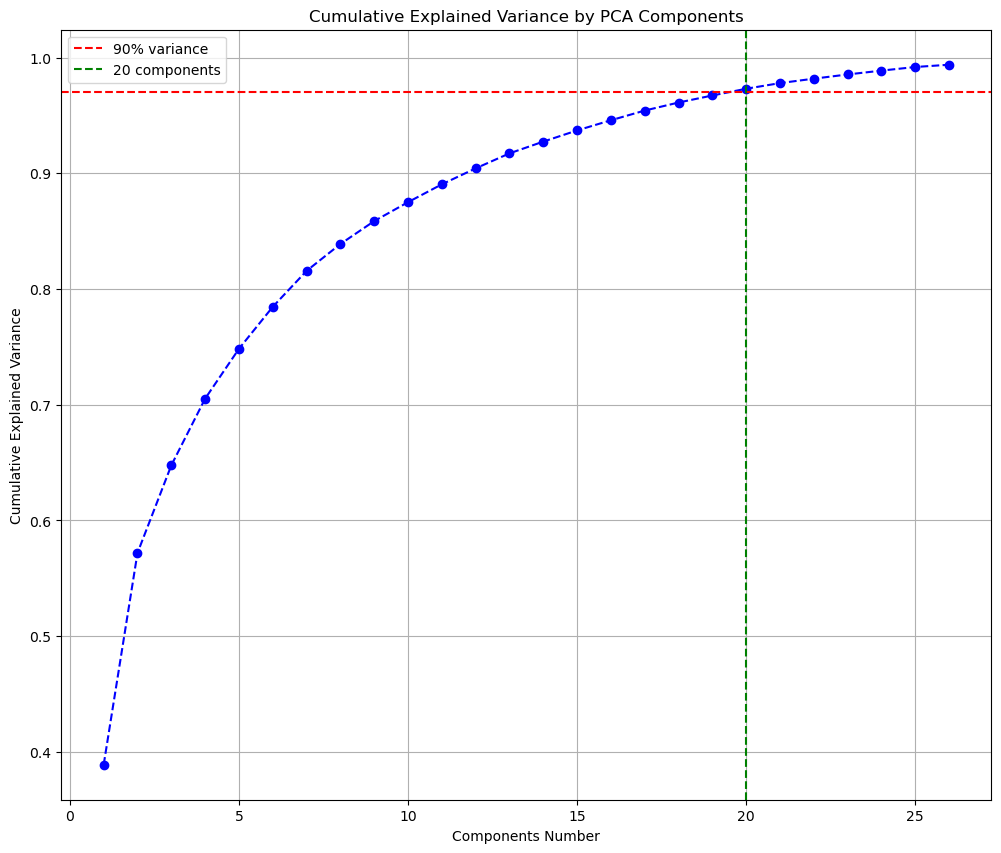

In [8]:
plts.plot_pca_variance(cumulative_var, n_components_97)

In [9]:
# Create a new PCA instance with the optimal number of components found (to explain 97% variance)
pca_opt = PCA(n_components=n_components_97)
X_pca_opt = pca_opt.fit_transform(X_scaled)

print("Data shape after optimal PCA:", X_pca_opt.shape)
print("Explained Variance:\n", pca.explained_variance_ratio_)

# Create a DataFrame for the optimally reduced data with appropriate PC column names
X_pca_opt_df = pd.DataFrame(X_pca_opt, columns=[f'PC{i}' for i in range(X_pca_opt.shape[1])])


Data shape after optimal PCA: (720, 20)
Explained Variance:
 [0.38889946 0.18302407 0.07570496 0.05762962 0.04306899 0.036288
 0.03105729 0.02322843 0.01979995 0.01636485 0.01542476 0.01378288
 0.01296057 0.01016648 0.00966474 0.00878968 0.00838489 0.00693677
 0.00608119 0.00582085 0.0048821  0.00382521 0.00363734 0.00332571
 0.00311854 0.0019705 ]


## Autoencoder Training

In [10]:
real_1, pred_1 = aek.Autoencoder(dataframe=X_pca_opt_df, features=X_pca_opt_df.columns.tolist(), epochs = 1000, latent_dim = 64, batch_size = 32)

Epoch 1/1000
16/16 [==============================] - 1s 4ms/step - loss: 0.0349 - mean_absolute_error: 0.1473
Epoch 2/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0305 - mean_absolute_error: 0.1350
Epoch 3/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0283 - mean_absolute_error: 0.1309
Epoch 4/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0254 - mean_absolute_error: 0.1248
Epoch 5/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0224 - mean_absolute_error: 0.1172
Epoch 6/1000
16/16 [==============================] - 0s 3ms/step - loss: 0.0197 - mean_absolute_error: 0.1098
Epoch 7/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0175 - mean_absolute_error: 0.1030
Epoch 8/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0153 - mean_absolute_error: 0.0961
Epoch 9/1000
16/16 [==============================] - 0s 4ms/step - loss: 0.0133 - mean_absolute_error: 0.0891
E

In [11]:
# Back to the original space|
pred_original_space_1 = pca_opt.inverse_transform(pred_1)
real_original_space_1 = pca_opt.inverse_transform(real_1)

## LSTM Training

In [12]:
real_2, pred_2 = lstmb.Autoencoder(dataframe=X_pca_opt_df, features=X_pca_opt_df.columns.tolist(), epochs = 150, latent_dim = 256, batch_size = 64, timesteps = 6)

Epoch 1/150
8/8 [==============================] - 2s 44ms/step - loss: 0.2092
Epoch 2/150
8/8 [==============================] - 0s 34ms/step - loss: 0.0848
Epoch 3/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0645
Epoch 4/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0516
Epoch 5/150
8/8 [==============================] - 0s 36ms/step - loss: 0.0433
Epoch 6/150
8/8 [==============================] - 0s 35ms/step - loss: 0.0368
Epoch 7/150
8/8 [==============================] - 0s 38ms/step - loss: 0.0335
Epoch 8/150
8/8 [==============================] - 0s 38ms/step - loss: 0.0326
Epoch 9/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0322
Epoch 10/150
8/8 [==============================] - 0s 33ms/step - loss: 0.0321
Epoch 11/150
8/8 [==============================] - 0s 37ms/step - loss: 0.0320
Epoch 12/150
8/8 [==============================] - 0s 34ms/step - loss: 0.0319
Epoch 13/150
8/8 [==============================]

In [13]:
# Back to the original space
pred_original_space_2 = pca_opt.inverse_transform(pred_2)
real_original_space_2 = pca_opt.inverse_transform(real_2)

## Results
Visualizing the results after the PCA procedures on the trained models through graphs with normalized errors.

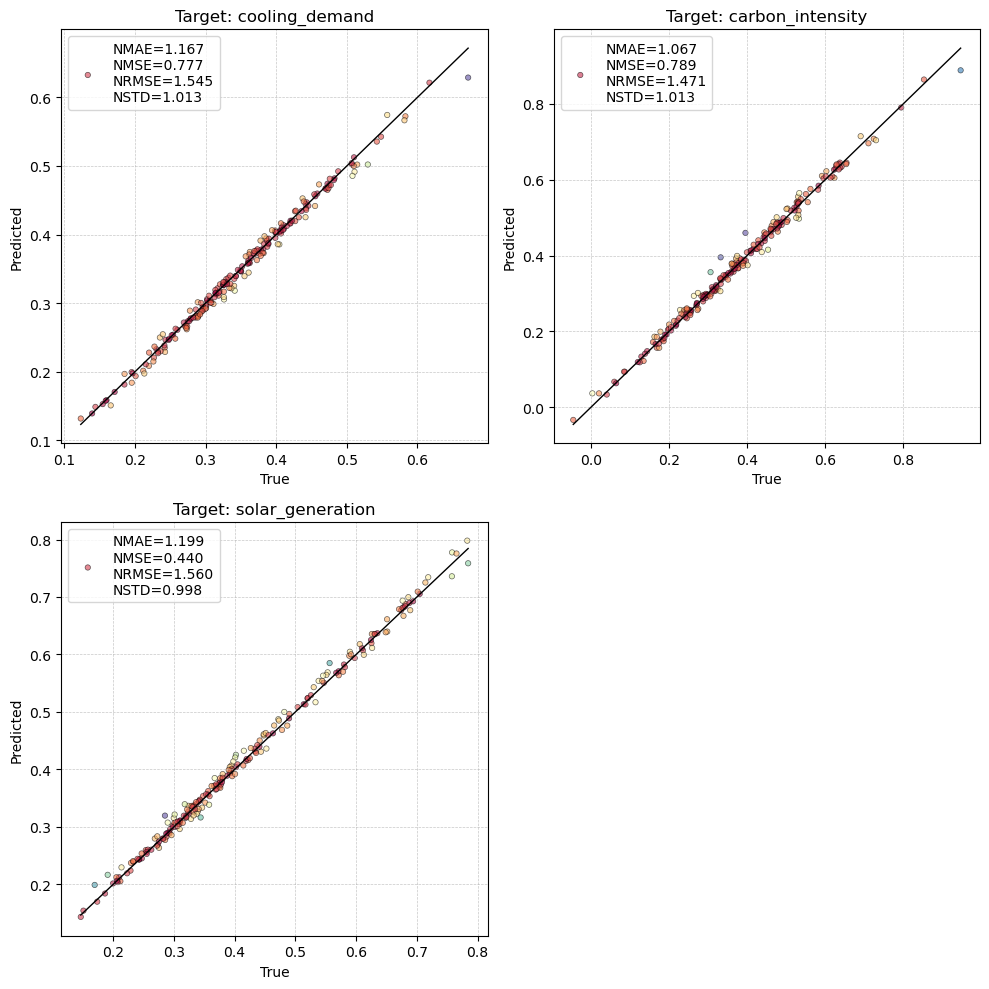

In [14]:
# Autoendoer
plts.plot_targets(real_original_space_1, pred_original_space_1, targets, features, percent=True)

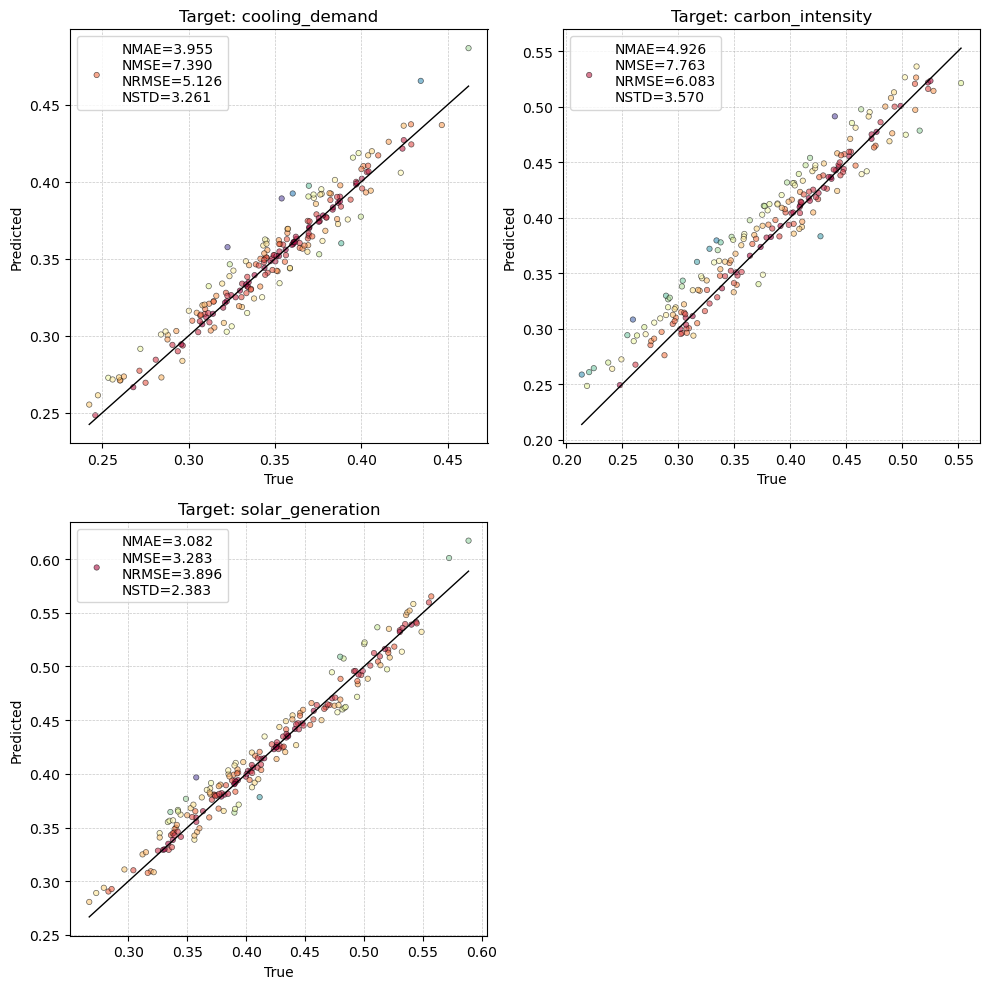

In [15]:
# LSTM
plts.plot_lstm_targets(real_original_space_2, pred_original_space_2, targets, features, percent=True)